**Advantages of using Decision Tree:**
1. Easy to Understand
2. Useful in Data Exploration
3. Less Data Cleaning is required. It is not easily influenced by the presence of outliers and missing values
4. Decision Tree can handle mixed data type. Hence Data type is not a constraint
5. Non Parametric method

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

## First Step: Loding the Data

In [3]:
df = pd.read_csv('DecisionTree-iris.csv')  # Adjust path if needed
print("Data Sample:")
print(df.head())

Data Sample:
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


## One-hot Encode Target Column (species)

In [6]:
encoder = OneHotEncoder(sparse_output=False)
encoded_species = encoder.fit_transform(df[['species']])
species_labels = encoder.get_feature_names_out(['species'])

In [8]:
# Convert back to DataFrame for inspection
encoded_df = pd.DataFrame(encoded_species, columns=species_labels)
print("\nEncoded Species:")
print(encoded_df.head())


Encoded Species:
   species_setosa  species_versicolor  species_virginica
0             1.0                 0.0                0.0
1             1.0                 0.0                0.0
2             1.0                 0.0                0.0
3             1.0                 0.0                0.0
4             1.0                 0.0                0.0


In [9]:
# Drop the original species and combine with encoded columns
df_encoded = pd.concat([df.drop('species', axis=1), encoded_df], axis=1)

In [11]:
df_encoded.tail()

,sepal_length,sepal_width,petal_length,petal_width,species_setosa,species_versicolor,species_virginica
145,6.7,3.0,5.2,2.3,0.0,0.0,1.0
146,6.3,2.5,5.0,1.9,0.0,0.0,1.0
147,6.5,3.0,5.2,2.0,0.0,0.0,1.0
148,6.2,3.4,5.4,2.3,0.0,0.0,1.0
149,5.9,3.0,5.1,1.8,0.0,0.0,1.0


In [13]:
species_labels

array(['species_setosa', 'species_versicolor', 'species_virginica'],
      dtype=object)

In [16]:
encoded_df.head(2)

,species_setosa,species_versicolor,species_virginica
0,1.0,0.0,0.0
1,1.0,0.0,0.0


## Define Features and Target

In [12]:
X = df_encoded.drop(columns=species_labels)
y = df['species']  # Use original target for classification

## Train Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

## Evaluate Model

In [27]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nAccuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 1.00
F1 Score: 1.00


## Confusion Matrix

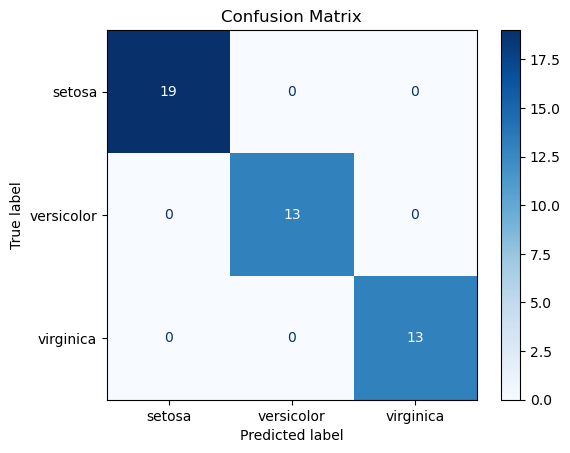

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Visualize the Tree

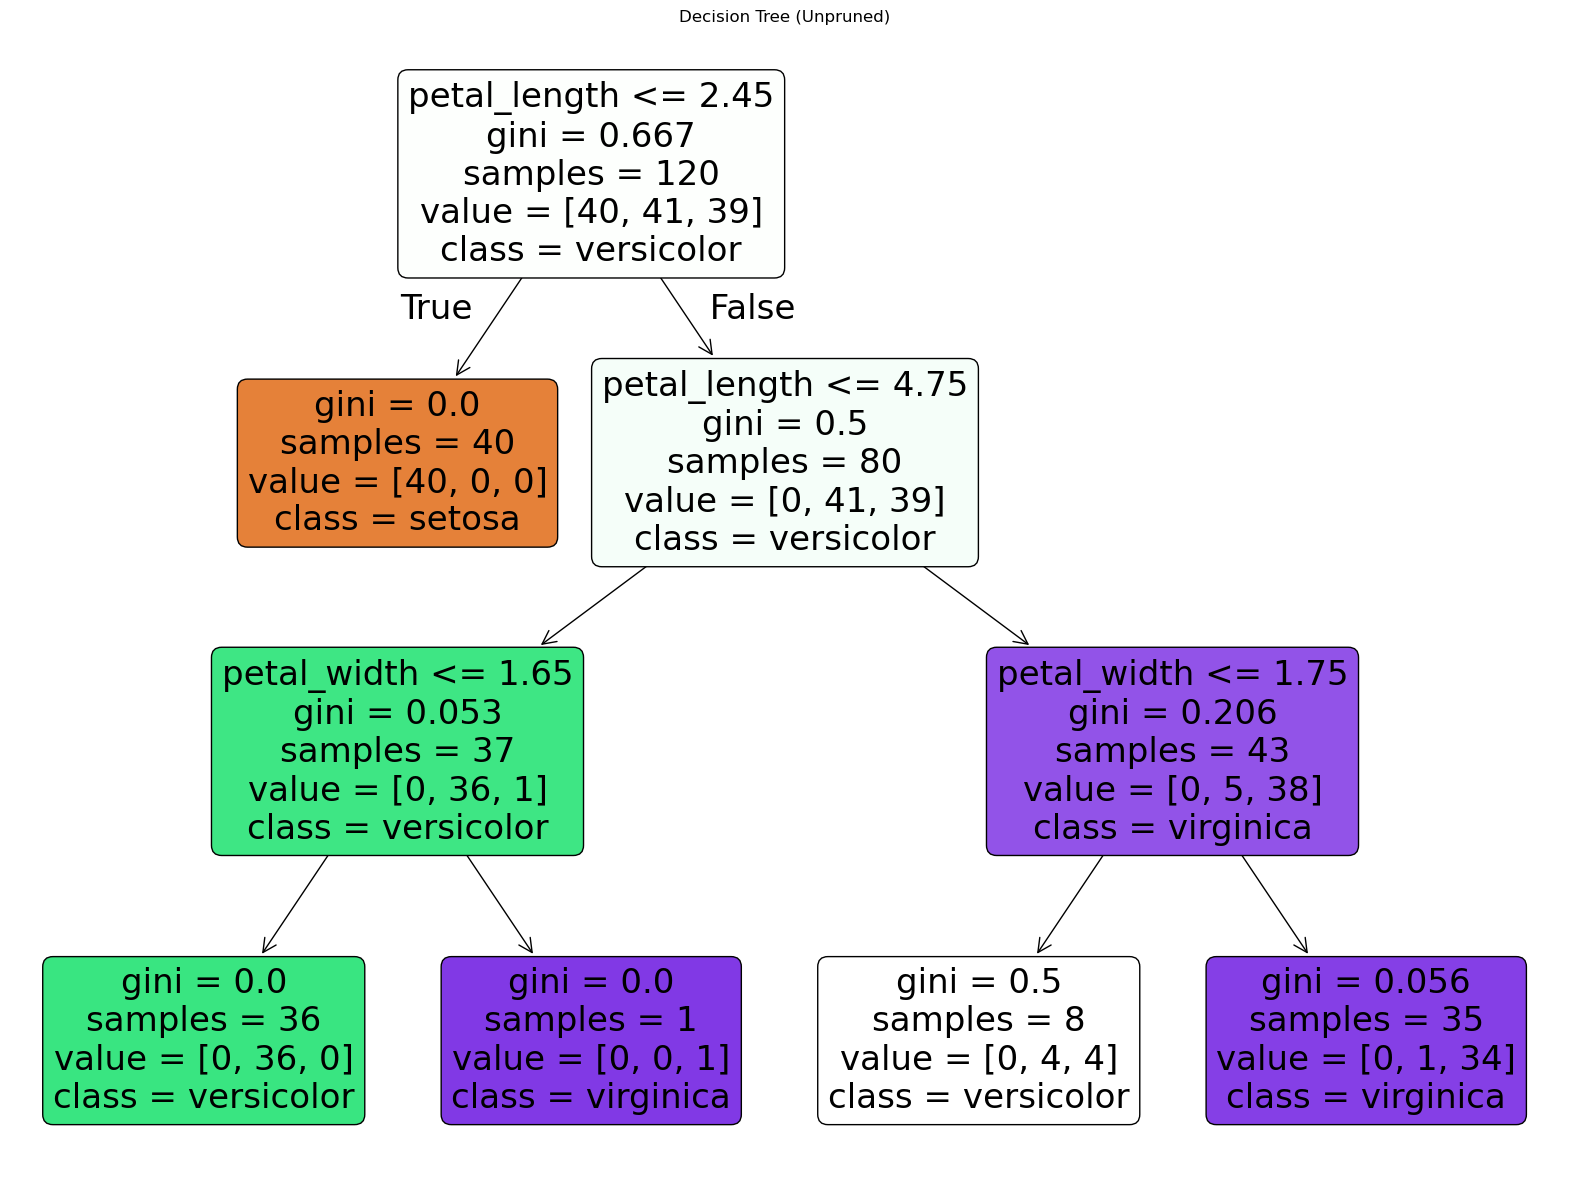

In [29]:
plt.figure(figsize=(20, 15))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.title("Decision Tree (Unpruned)")
plt.show()

## Prune the tree to prevent overfitting

In [30]:
# Use cost complexity pruning to find the optimal ccp_alpha
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
clfs = []

# Train Model for each ccp_alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

### Evaluate all pruned models

In [31]:
train_scores = [model.score(X_train, y_train) for model in clfs]
test_scores = [model.score(X_test, y_test) for model in clfs]

In [32]:
print(train_scores)
print(test_scores)

[1.0, 0.95, 0.95, 0.675]
[1.0, 1.0, 0.9666666666666667, 0.6333333333333333]


### Plot training vs testing accuracy to find optimal pruning point

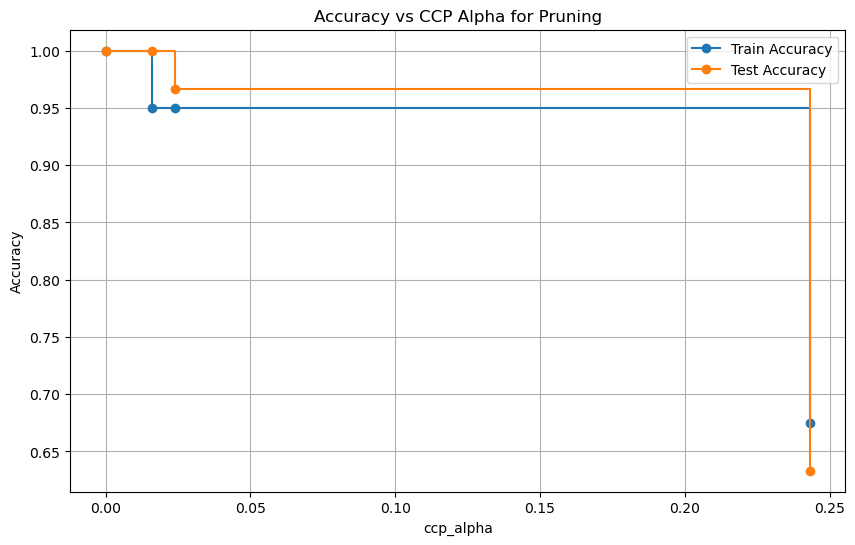

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs CCP Alpha for Pruning")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# 📌 Select best pruned model (manually or by max test score)
best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
print(f"Best alpha: {best_alpha:.4f}")

Best alpha: 0.0000


In [35]:
# Final model with best ccp_alpha
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

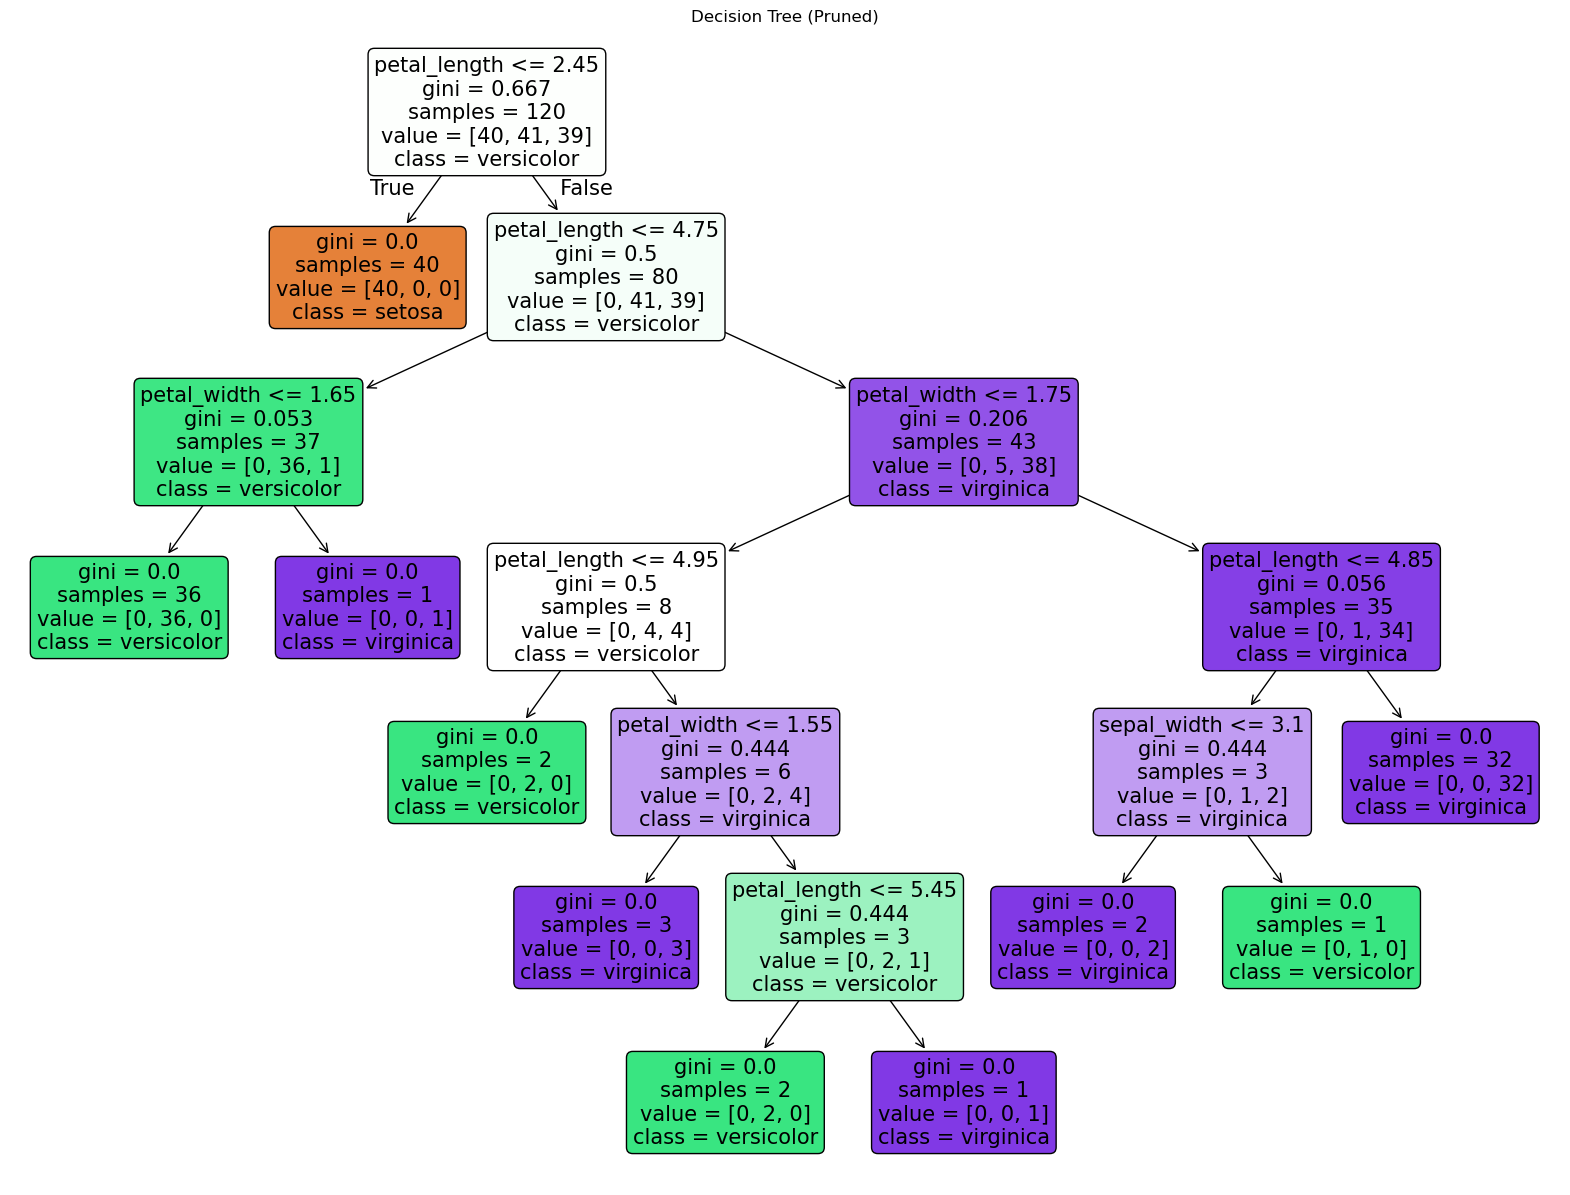

In [39]:
# 📌 Visualize Pruned Tree
plt.figure(figsize=(20, 15))
plot_tree(pruned_clf, feature_names=X.columns, class_names=pruned_clf.classes_, filled=True, rounded=True)
plt.title("Decision Tree (Pruned)")
plt.show()